In [96]:
import pandas as pd
import numpy as np
import retrieval_311
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns

import matplotlib.ticker as mtick

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from keras.regularizers import l2

In [2]:
df = pd.read_csv("data/processed_data.csv")

In [3]:
df.head()

,Unnamed: 0,datetime,calls,month,dayofweek,dayofmonth,hourofday
0,0,2008-07-01 00:00:00,2,7,1,1,0
1,1,2008-07-01 01:00:00,0,7,1,1,1
2,2,2008-07-01 02:00:00,0,7,1,1,2
3,3,2008-07-01 03:00:00,1,7,1,1,3
4,4,2008-07-01 04:00:00,0,7,1,1,4


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'],format="%Y-%m-%d")
df = df[(df['datetime'].dt.year > 2008) & (df['datetime'].dt.year < 2023)]

In [5]:
df = df.set_index('datetime')

In [6]:
df = df.drop("Unnamed: 0", axis=1)

In [7]:
df['calls'].describe()

count    122712.000000
mean         17.626622
std          22.591759
min           0.000000
25%           2.000000
50%           8.000000
75%          25.000000
max         553.000000
Name: calls, dtype: float64

In [8]:
df['calls'].sum()

2162998

In [11]:
df['year'] = df.index.year
df['date'] = df.index.date

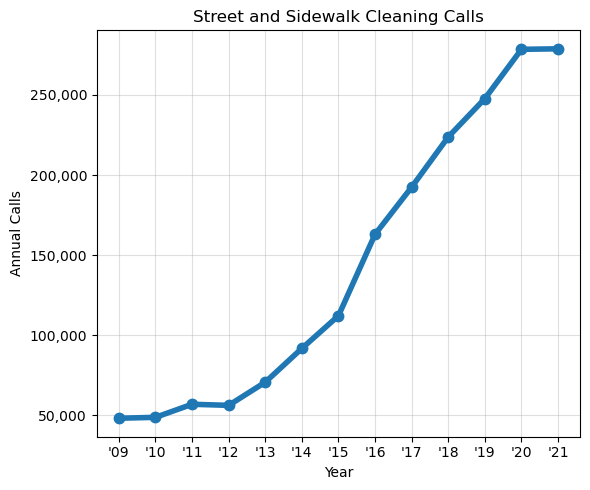

In [10]:
year_group = df.groupby("year")['calls'].sum()
year_group = year_group.iloc[:-1]

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(year_group, ".-", linewidth=4, markersize=15)
ax.set_xticks(year_group.index)
ax.set_xticklabels(["'"+str(y)[-2:] for y in year_group.index])
ax.grid(alpha=.4)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set(title="Street and Sidewalk Cleaning Calls", xlabel="Year", ylabel="Annual Calls")
fig.tight_layout()
fig.savefig("figures/annual_trend.png", dpi=300)

In [12]:
def evaluate_fit(actual_calls, test_preds):
    rmse = np.mean((actual_calls - test_preds)**2)**.5
    r2 = r2_score(actual_calls, test_preds)
    max_resid = np.max(np.abs(actual_calls - test_preds))
    print("rmse", rmse)
    print("r2", r2)
    print("max resid", max_resid)
    return rmse, r2, max_resid


In [13]:
all_years = df.index.year.unique()

print("----- Naive Baseline Model -----")
rmses = []
r2s = []
max_resids = []
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = df[df.index.year == all_years[i]]
    test_data = df[df.index.year == all_years[i+1]]
    lag = 24*2
    test_preds = train_data['calls'].shift(lag).dropna()
    test_preds.index = test_preds.index + pd.DateOffset(years=1)
    actual_calls = test_data['calls'].iloc[lag:]
    merged = pd.merge(test_preds, actual_calls, left_index=True, right_index=True)
    actual_calls = merged['calls_y']
    test_preds = merged['calls_x']
    rmse, r2, max_resid = evaluate_fit(actual_calls, test_preds)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)
print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))
    

----- Naive Baseline Model -----
2009 --> 2010
rmse 5.609386810131294
r2 0.2004180223499794
max resid 38.0
2010 --> 2011
rmse 6.305552015953506
r2 0.24044542701890992
max resid 41.0
2011 --> 2012
rmse 6.551265307937561
r2 0.18907831378440365
max resid 117.0
2012 --> 2013
rmse 7.450316203924605
r2 0.24800447678655924
max resid 133.0
2013 --> 2014
rmse 8.926647306776358
r2 0.3461654111005241
max resid 152.0
2014 --> 2015
rmse 10.190725946506678
r2 0.3378691038852478
max resid 142.0
2015 --> 2016
rmse 14.566150837800919
r2 0.35390855235440943
max resid 105.0
2016 --> 2017
rmse 15.55052029093179
r2 0.4531249436179995
max resid 91.0
2017 --> 2018
rmse 17.036472380882522
r2 0.5011373804374825
max resid 239.0
2018 --> 2019
rmse 18.018043960780965
r2 0.5542244910779695
max resid 263.0
2019 --> 2020
rmse 19.441971179448757
r2 0.5620363490435625
max resid 289.0
2020 --> 2021
rmse 21.3977838964145
r2 0.5667698208998744
max resid 442.0

Mean RMSE: 12.587069678124122
Mean r2: 0.37943185769641014
Ma

In [92]:
# all_years = df.index.year.unique()

# rmses = []
# r2s = []
# max_resids = []
# for i in range(len(all_years)-2):
#     print(all_years[i], "-->", all_years[i+1])
#     train_data = df[df.index.year == all_years[i]]
#     test_data = df[df.index.year == all_years[i+1]]
#     preds = (train_data
#              .groupby(['date', 'hourofday'])
#              ['calls']
#              .mean()).to_dict()
#     test_preds = (
#         test_data
#         .apply(lambda x: preds.get(((x.date - pd.DateOffset(years=1)).to_pydatetime().date(),
#                                     x.hourofday)),
#                 axis=1)
#     )
#     print(test_preds.isna().sum())
#     rmse = np.mean((test_data['calls'] - test_preds)**2)**.5
#     r2 = r2_score(test_data['calls'], test_preds, )
#     max_resid = np.max(np.abs(test_data['calls'] - test_preds))
#     print("rmse", rmse)
#     print("r2", r2)
#     print("max resid", max_resid)
#     rmses.append(rmse)
#     r2s.append(r2)
#     max_resids.append(max_resid)
# print("Mean RMSE:", np.mean(rmses))
# print("Mean r2:", np.mean(r2s))
# print("Max resid:", np.mean(max_resids))
    

In [93]:
# all_years = df.index.year.unique()

# rmses = []
# for i in range(len(all_years)-2):
#     print(all_years[i], "-->", all_years[i+1])
#     train_data = df[df.index.year == all_years[i]]
#     test_data = df[df.index.year == all_years[i+1]]
#     preds = (train_data
#              .groupby([train_data['month'],
#                        train_data['dayofmonth'],
#                        train_data['hourofday']])
#              ['calls']
#              .max()).to_dict()
#     test_preds = (
#         test_data
#         .apply(lambda x: preds.get((x.month,
#                                     x.dayofmonth,
#                                     x.hourofday)),
#                 axis=1)
#     )
#     rmse = np.mean((test_data['calls'] - test_preds)**2)**.5
#     print(rmse)
#     rmses.append(rmse)
# print("Mean RMSE:", np.mean(rmses))
    

In [103]:
# df

In [14]:
n_steps = 48
X_ = df.copy()[['calls']]
for i in range(1, n_steps+1):
    X_[f'lag_{i}'] = X_['calls'].shift(i)

In [15]:
X_ = X_.dropna()

In [85]:
X_.corr()

,calls,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48
calls,1.000000,0.848958,0.714361,0.577899,0.447423,0.325441,0.210614,0.103827,0.001355,-0.091820,...,-0.105373,-0.014764,0.084546,0.188583,0.298118,0.415495,0.539678,0.664726,0.771735,0.816813
lag_1,0.848958,1.000000,0.848958,0.714361,0.577899,0.447423,0.325441,0.210614,0.103830,0.001354,...,-0.177238,-0.105362,-0.014754,0.084546,0.188584,0.298118,0.415494,0.539678,0.664726,0.771735
lag_2,0.714361,0.848958,1.000000,0.848959,0.714362,0.577899,0.447424,0.325441,0.210616,0.103829,...,-0.223379,-0.177227,-0.105352,-0.014751,0.084549,0.188586,0.298119,0.415496,0.539679,0.664727
lag_3,0.577899,0.714361,0.848959,1.000000,0.848959,0.714363,0.577900,0.447424,0.325443,0.210615,...,-0.238709,-0.223370,-0.177219,-0.105349,-0.014748,0.084551,0.188588,0.298121,0.415497,0.539681
lag_4,0.447423,0.577899,0.714362,0.848959,1.000000,0.848959,0.714363,0.577900,0.447427,0.325441,...,-0.222328,-0.238698,-0.223360,-0.177216,-0.105347,-0.014747,0.084552,0.188589,0.298122,0.415498
lag_5,0.325441,0.447423,0.577899,0.714363,0.848959,1.000000,0.848960,0.714363,0.577902,0.447425,...,-0.174927,-0.222319,-0.238690,-0.223358,-0.177214,-0.105345,-0.014746,0.084553,0.188590,0.298124
lag_6,0.210614,0.325441,0.447424,0.577900,0.714363,0.848960,1.000000,0.848959,0.714365,0.577901,...,-0.102228,-0.174920,-0.222312,-0.238687,-0.223355,-0.177212,-0.105343,-0.014744,0.084555,0.188592
lag_7,0.103827,0.210614,0.325441,0.447424,0.577900,0.714363,0.848959,1.000000,0.848960,0.714365,...,-0.012312,-0.102230,-0.174921,-0.222312,-0.238687,-0.223355,-0.177212,-0.105343,-0.014745,0.084555
lag_8,0.001355,0.103830,0.210616,0.325443,0.447427,0.577902,0.714365,0.848960,1.000000,0.848963,...,0.086367,-0.012322,-0.102237,-0.174919,-0.222310,-0.238684,-0.223352,-0.177209,-0.105342,-0.014742
lag_9,-0.091820,0.001354,0.103829,0.210615,0.325441,0.447425,0.577901,0.714365,0.848963,1.000000,...,0.190507,0.086370,-0.012321,-0.102239,-0.174920,-0.222312,-0.238686,-0.223354,-0.177210,-0.105343


In [16]:
# X = X_.dropna().drop('calls', axis=1)

In [17]:
# X.shape

In [18]:
# X = X.values

In [19]:
# y = X_.dropna()['calls'].values

In [20]:
# train_ind = int(len(y)*.8)

In [83]:
all_years = df.index.year.unique()
rmses = []
r2s = []
max_resids = []

print("----- Regression With Lags -----")
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = X_[X_.index.year == all_years[i]]
    test_data = X_[X_.index.year == all_years[i+1]]

    X_train = train_data.drop('calls', axis=1).values
    y_train = train_data[['calls']].values
    X_test = test_data.drop('calls', axis=1).values
    y_test = test_data[['calls']].values

    scaler_X = StandardScaler()
    scaler_X.fit(X_train)
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    X_train_scaled = np.clip(X_train_scaled, -3, 3)
    X_test_scaled = np.clip(X_test_scaled, -3, 3)

    lm = LinearRegression()
    lm.fit(X_train_scaled, y_train_scaled)
    test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled))
    actual_calls = y_test
    rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)

print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))

----- Regression With Lags -----
2009 --> 2010
rmse 3.7693269749331217
r2 0.42702776226472905
max resid 29.18288986337003
2010 --> 2011
rmse 4.367847771353403
r2 0.39352916745044175
max resid 37.70959016164434
2011 --> 2012
rmse 4.513121121967147
r2 0.38289401659104416
max resid 126.26354242643939
2012 --> 2013
rmse 4.804020277195866
r2 0.5093591595603264
max resid 35.26866028585498
2013 --> 2014
rmse 6.248891650160857
r2 0.49631429981022046
max resid 151.3967777481542
2014 --> 2015
rmse 6.538795258238863
r2 0.6165287351622348
max resid 70.79267581607405
2015 --> 2016
rmse 9.200039380382208
r2 0.5971082083755457
max resid 96.3364571486492
2016 --> 2017
rmse 9.159397358157154
r2 0.7544116305634567
max resid 85.5076332372751
2017 --> 2018
rmse 10.880094678124307
r2 0.7406458973800923
max resid 219.96825970832916
2018 --> 2019
rmse 11.731135875710885
r2 0.7645793439620926
max resid 262.655132359646
2019 --> 2020
rmse 12.62038694526827
r2 0.7723444852865617
max resid 256.7704331827631
2020

In [84]:
all_years = df.index.year.unique()
rmses = []
r2s = []
max_resids = []

print("----- Ridge Regression With Lags -----")
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = X_[X_.index.year == all_years[i]]
    test_data = X_[X_.index.year == all_years[i+1]]

    X_train = train_data.drop('calls', axis=1).values
    y_train = train_data[['calls']].values
    X_test = test_data.drop('calls', axis=1).values
    y_test = test_data[['calls']].values

    scaler_X = StandardScaler()
    scaler_X.fit(X_train)
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    X_train_scaled = np.clip(X_train_scaled, -3, 3)
    X_test_scaled = np.clip(X_test_scaled, -3, 3)

    lm = RidgeCV(alphas=np.linspace(0.0001, 1, 30), scoring="r2", cv=TimeSeriesSplit(n_splits=4))
    lm.fit(X_train_scaled, y_train_scaled)
    test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled))
    actual_calls = y_test
    rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)

print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))


----- Ridge Regression With Lags -----
2009 --> 2010
rmse 3.769331411390137
r2 0.42698291253335185
max resid 29.183068121920485
2010 --> 2011
rmse 4.367843397640271
r2 0.3934838538842056
max resid 37.70817796081691
2011 --> 2012
rmse 4.51311126122042
r2 0.3828477733372906
max resid 126.26311254908566
2012 --> 2013
rmse 4.8040497562727635
r2 0.5093177244728688
max resid 35.26874439287556
2013 --> 2014
rmse 6.248918572469018
r2 0.4962761948195026
max resid 151.3987206030451
2014 --> 2015
rmse 6.538813978291443
r2 0.6165015169029531
max resid 70.79452451354015
2015 --> 2016
rmse 9.200267332649378
r2 0.5970630110872404
max resid 96.33739042399566
2016 --> 2017
rmse 9.159565881930877
r2 0.7543824198996067
max resid 85.50276644204328
2017 --> 2018
rmse 10.880152977262053
r2 0.74061820435455
max resid 219.97660506620207
2018 --> 2019
rmse 11.731135869216518
r2 0.764579342114099
max resid 262.65513226088063
2019 --> 2020
rmse 12.620406161781851
r2 0.7723248325276224
max resid 256.7944542962819

In [ ]:
all_years = df.index.year.unique()
rmses = []
r2s = []
max_resids = []

print("----- Ridge Regression With Lags -----")
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = X_[X_.index.year == all_years[i]]
    test_data = X_[X_.index.year == all_years[i+1]]

    X_train = train_data.drop('calls', axis=1).values
    y_train = train_data[['calls']].values
    X_test = test_data.drop('calls', axis=1).values
    y_test = test_data[['calls']].values

    scaler_X = StandardScaler()
    scaler_X.fit(X_train)
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    X_train_scaled = np.clip(X_train_scaled, -3, 3)
    X_test_scaled = np.clip(X_test_scaled, -3, 3)

    lm = RidgeCV(alphas=np.linspace(0.0001, 1, 30), scoring="r2", cv=TimeSeriesSplit(n_splits=4))
    lm.fit(X_train_scaled, y_train_scaled)
    test_preds = scaler_y.inverse_transform(lm.predict(X_test_scaled))
    actual_calls = y_test
    rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)

print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))


In [100]:
import tensorflow.keras.backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [109]:
all_years = df.index.year.unique()
rmses = []
r2s = []
max_resids = []

print("----- Vanilla RNN With Lags -----")
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = X_[X_.index.year == all_years[i]]
    test_data = X_[X_.index.year == all_years[i+1]]

    X_train = train_data.drop('calls', axis=1).values
    y_train = train_data[['calls']].values
    X_test = test_data.drop('calls', axis=1).values
    y_test = test_data[['calls']].values

    scaler_X = StandardScaler()
    scaler_X.fit(X_train)
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    X_train_scaled = np.clip(X_train_scaled, -3, 3)
    X_test_scaled = np.clip(X_test_scaled, -3, 3)

    model = Sequential()
    model.add(SimpleRNN(200, activation='relu', return_sequences=True, input_shape=(n_steps, 1)), )
    model.add(Dropout(0.8))
    model.add(SimpleRNN(units=150, activation='relu', return_sequences=True))
    model.add(Dropout(0.6))
    model.add(SimpleRNN(units=100, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(SimpleRNN(units=50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit the model to the training data
    model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1),
              y_train_scaled,
              batch_size=100,
              epochs=6)
    # make predictions for test data
    predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

    test_preds = scaler_y.inverse_transform(predictions)
    actual_calls = y_test
    print("Train")
    evaluate_fit(scaler_y.inverse_transform(model.predict(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1))),
                 y_train)
    print("Test")
    rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)
    rmses.append(rmse)
    r2s.append(r2)
    max_resids.append(max_resid)

print()
print("Mean RMSE:", np.mean(rmses))
print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))


----- Vanilla RNN With Lags -----
2009 --> 2010
Epoch 1/6
88/88 [==============================] - 30s 286ms/step - loss: 0.8465
Epoch 2/6
88/88 [==============================] - 28s 318ms/step - loss: 0.6393
Epoch 3/6
88/88 [==============================] - 31s 351ms/step - loss: 0.6056
Epoch 4/6
88/88 [==============================] - 27s 307ms/step - loss: 0.5774
Epoch 5/6
88/88 [==============================] - 27s 306ms/step - loss: 0.5354
Epoch 6/6
274/274 [==============================] - 19s 67ms/step
Train
273/273 [==============================] - 22s 80ms/step
rmse 4.102100142637915
r2 -0.4471552673312975
max resid 33.528743743896484
Test
rmse 4.4683125507703565
r2 -0.029087220966261373
max resid 31.00409460067749
2010 --> 2011
Epoch 1/6
88/88 [==============================] - 37s 295ms/step - loss: 0.8731
Epoch 2/6
88/88 [==============================] - 24s 269ms/step - loss: 0.6391
Epoch 3/6
88/88 [==============================] - 24s 273ms/step - loss: 0.5897
Epo

In [97]:
train_data = X_.iloc[:80000, :]
test_data = X_.iloc[80000:, :]

X_train = train_data.drop('calls', axis=1).values
y_train = train_data[['calls']].values
X_test = test_data.drop('calls', axis=1).values
y_test = test_data[['calls']].values

scaler_X = StandardScaler()
scaler_X.fit(X_train)
scaler_y = StandardScaler()
scaler_y.fit(y_train)

X_train_scaled = scaler_X.transform(X_train)
y_train_scaled = scaler_y.transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

X_train_scaled = np.clip(X_train_scaled, -3, 3)
X_test_scaled = np.clip(X_test_scaled, -3, 3)

model = Sequential()
model.add(LSTM(48, activation='relu', input_shape=(n_steps, 1)), )
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit the model to the training data
model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1),
            y_train_scaled,
            batch_size=30,
            epochs=5)
# make predictions for test data
predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

test_preds = scaler_y.inverse_transform(predictions)
actual_calls = y_test
print("Train")
evaluate_fit(scaler_y.inverse_transform(model.predict(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1))),
                y_train)
print("Test")
rmse, r2, max_resid = evaluate_fit(test_preds, actual_calls)

Epoch 1/5
 341/2667 [==>...........................] - ETA: 1:09 - loss: 0.6268

KeyboardInterrupt: 

In [77]:
pd.Series(np.ravel(actual_calls))

0       1
1       0
2       0
3       0
4       0
       ..
8755    2
8756    0
8757    0
8758    1
8759    1
Length: 8760, dtype: int64

In [73]:
r2_score(pd.Series(np.ravel(actual_calls)), pd.Series(np.ravel(test_preds)))

-2.97131070259196

In [69]:
np.corrcoef(actual_calls, test_preds)

c:\Users\peteramerkhanian\anaconda3\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\peteramerkhanian\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\peteramerkhanian\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])